### Deeper CNN on FashionMNIST - AlexNet
Roger Wang  
UCLA

In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from torch.optim import SGD
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
# FashionMNIST dataset
class FashionMNIST():
    def __init__(self, root='../data', batch_size=64, resize=(28,28)):
        self.batch_size = batch_size
        self.resize = resize

        # image transforms, resize and convert to tensor
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])

        # initialize train (60k) and val (10k) sets
        self.train = torchvision.datasets.FashionMNIST(root=root,train=True,transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(root=root,train=False,transform=trans,download=True)

    # data loader for dataset
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return DataLoader(data, self.batch_size, shuffle=train)
    
    # getting training data
    def train_dataloader(self):
        return self.get_dataloader(True)
    
    # getting val data
    def val_dataloader(self):
        return self.get_dataloader(False)

In [7]:
# AlexNet class
class AlexNet(nn.Module):
    def __init__(self, outputs, lr, momentum, weight_decay):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        # same parameters as paper
        self.net = nn.Sequential(nn.LazyConv2d(out_channels=96,kernel_size=11,stride=4),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.LazyConv2d(out_channels=256,kernel_size=5,padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.LazyConv2d(out_channels=384,kernel_size=3,padding=1),nn.ReLU(),
                                 nn.LazyConv2d(out_channels=384,kernel_size=3,padding=1),nn.ReLU(),
                                 nn.LazyConv2d(out_channels=256,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.Flatten(),
                                 nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
                                 nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
                                 nn.LazyLinear(outputs))

    def forward(self, x):
        return self.net(x)

    # cross-entropy loss
    def loss(self, batch):
        logits, labels = batch
        return F.cross_entropy(logits, labels) # mean reduction default

    def accuracy(self, batch, averaged=True):
        logits, labels = batch
        logits, labels = logits.to('cpu'), labels.to('cpu')
        predict = self.predict(logits).type(labels.dtype)
        compare = (predict == labels).type(torch.float32) # bc predict now on cpu
        return compare.mean() if averaged else compare

    def predict(self, logits):
        return logits.argmax(axis=1) # issue w argmax on gpu

    def initOptimizer(self):
        self.optim = SGD(self.parameters(), self.lr, self.momentum, self.weight_decay)

In [6]:
# early stopper and training loop

# early stopping class
# criterion: validation accuracy
class EarlyStop():
    def __init__(self, patience, delta=0.003):
        self.patience = patience
        self.delta = delta
        self.best = 0
        self.count = 0

    def checkForStop(self, acc):
        if acc > self.best:
            self.best = acc
            self.count = 0
            return False
        elif acc < self.best-self.delta:
            if self.count > self.patience:
                return True
            self.count = self.count + 1
            return False
        
# training loop
def train(model, trainloader, valloader, epochs):
    train_loss = []
    val_loss = []
    val_acc = []
    model.initOptimizer()
    mps = torch.device('mps')
    model.to(mps)
    stopper = EarlyStop(3)

    pbar = tqdm(range(epochs))
    for i in range(epochs):
        train_loss.append(0)
        val_loss.append(0)
        val_acc.append(0)

        model.train()
        # training over batches of train set
        for n, (traindata,trainlabel) in enumerate(trainloader):
            traindata, trainlabel = traindata.to(mps), trainlabel.to(mps)
            model.optim.zero_grad()
            logits = model.forward(traindata)
            loss = model.loss((logits,trainlabel))
            loss.backward()
            model.optim.step()

            train_loss[i] = train_loss[i] + loss.item()
        train_loss[i] = train_loss[i] / len(trainloader)

        # validation over batches of val set
        model.eval()
        for n, (val,vallabel) in enumerate(valloader):
            val, vallabel = val.to(mps), vallabel.to(mps)
            with torch.no_grad():
                logits = model.forward(val)
                loss = model.loss((logits,vallabel))
                accuracy = model.accuracy((logits,vallabel))

                val_loss[i] = val_loss[i] + loss.item()
                val_acc[i] = val_acc[i] + accuracy
        val_loss[i] = val_loss[i] / len(valloader)
        val_acc[i] = val_acc[i] / len(valloader)

        # update pbar
        pbar.update(1)
        pbar.set_description(f'val_acc: {val_acc[i]:.3f} train_loss: {train_loss[i]:.3f}')

        # check for early stopping
        if stopper.checkForStop(val_acc[i]):
            break

    pbar.close()

    # display loss and acc
    #plt.plot(train_loss, label='train_loss')
    #plt.plot(val_loss, label='val_loss')
    plt.plot(val_acc)
    plt.xlabel('epoch')
    #plt.legend()

In [8]:
# initialize dataset and model
mps = torch.device('mps')
data = FashionMNIST(batch_size=128,resize=(256,256))
model = AlexNet(10,lr=0.1,momentum=0,weight_decay=0)
model.to(mps)

/Users/rogerwang/opt/anaconda3/envs/torchKernel/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


AlexNet(
  (net): Sequential(
    (0): LazyConv2d(0, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): LazyLinear(in_features=0, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): LazyLinear(in_features=0, out_features=4096, bias=True)
    (18): ReLU()
    (1

val_acc: 0.785 train_loss: 1.660: 100%|██████████| 10/10 [2:56:27<00:00, 1058.77s/it] 


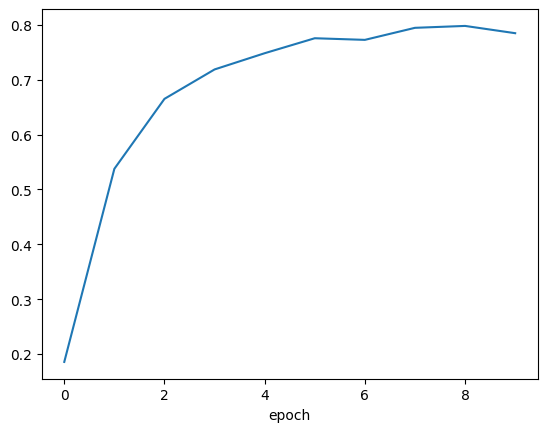

In [11]:
train(model,data.train_dataloader(),data.val_dataloader(),epochs=10)

AlexNet has good initial performance that could likely be improved with better hyperparameter search and longer training time. However, the deep model takes a while to train on the host machine (Macbook Air M2).  
  
Although the deep model performs well, for simple datasets like FashionMNIST, complex models are not really necessary, and increase the risk of overfitting since larger models have deeper capacities that may not be needed for simple datasets.

In [5]:
# classification metrics
def classification_metrics(true, pred, labels=None):
    # turn tensors to arrays, make sure same type
    true, pred = np.array(true).astype(int), np.array(pred).astype(int) 
    
    # create confusion matrix
    cm = confusion_matrix(true,pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(xticks_rotation='vertical')

    # TP,TN,FP,FN
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    # precision and recall by class
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)

    # macro averaged precision and recall
    N = len(precision)
    macro_precision = np.sum(precision) / N
    macro_recall = np.sum(recall) / N

    # micro averaged precision and recall
    micro_precision = np.sum(tp) / (np.sum(tp)+np.sum(fp))
    micro_recall = np.sum(tp) / (np.sum(tp)+np.sum(fn))

    # accuracy by class
    class_accuracy = (tp+tn) / (tp+fn+fp+tn)

    # overall accuracy
    accuracy = (true == pred).mean()

    # print metrics
    if labels is None:
        labels = np.unique(true)
    print(f' Class: \t\t Accuracy: \t\t Precision: \t\t Recall: \t\t')
    for i in range(N):
        print(f'  {labels[i]}: \t\t\t {class_accuracy[i]:.3f}\t\t\t {precision[i]:.3f}\t\t\t {recall[i]:.3f}')
    print(f'\n Overall Accuracy: \t{accuracy:.3f}')
    print(f' Macro Precision: \t{macro_precision:.3f} \t\t Micro Precision: \t{micro_precision:.3f}')
    print(f' Macro Recall: \t\t{macro_recall:.3f} \t\t Micro Recall: \t\t{micro_recall:.3f}')

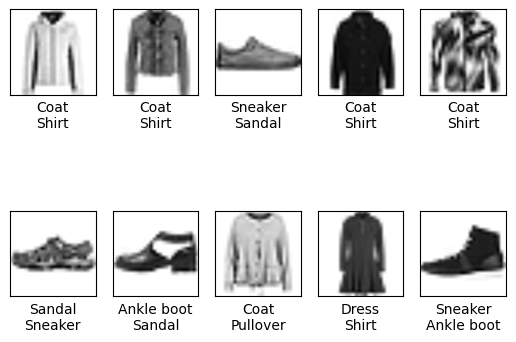

In [28]:
# where did model fail
data_2 = FashionMNIST(batch_size=500,resize=(256,256))
testloader = data_2.val_dataloader()
testdata, testlabel = next(iter(testloader))
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model.to('cpu')
model.eval()
logits = model.forward(testdata)
pred = model.predict(logits)

missed_idx = np.array((pred != testlabel).type(torch.float32))
missed_idx = np.where(missed_idx == 1)

missed = (testdata[missed_idx], testlabel[missed_idx], pred[missed_idx])

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(missed[0][i][0]), cmap=plt.cm.binary)
    plt.xlabel(labels[missed[1][i].item()] + '\n' + labels[missed[2][i]])

 Class: 		 Accuracy: 		 Precision: 		 Recall: 		
  T-shirt/top: 			 0.978			 0.893			 0.909
  Trouser: 			 0.998			 1.000			 0.981
  Pullover: 			 0.910			 0.643			 0.692
  Dress: 			 0.972			 0.820			 0.891
  Coat: 			 0.886			 nan			 0.000
  Sandal: 			 0.992			 0.927			 0.974
  Shirt: 			 0.878			 0.422			 0.809
  Sneaker: 			 0.984			 0.953			 0.872
  Bag: 			 0.988			 0.896			 0.977
  Ankle boot: 			 0.986			 0.902			 0.958

 Overall Accuracy: 	0.786
 Macro Precision: 	nan 		 Micro Precision: 	0.786
 Macro Recall: 		0.806 		 Micro Recall: 		0.786


/var/folders/rl/kfwnr9bn039czmp7dm8_ycmm0000gn/T/ipykernel_19566/15989414.py:18: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp+fp)


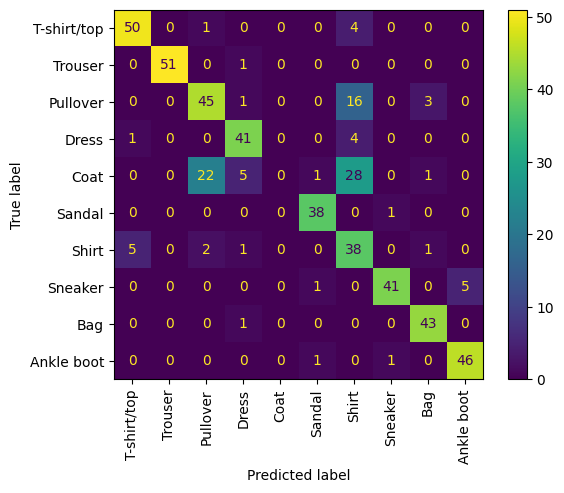

In [29]:
# display classification metrics
classification_metrics(testlabel,pred,labels=labels)

As seen in the MLP notebook, the model does horribly in visually ambigious classes such as coat. Try adding dropout to last layer to reduce label noise.

In [6]:
# AlexNet with dropout at last layer
class AlexNet2(nn.Module):
    def __init__(self, outputs, lr, momentum, weight_decay):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        self.net = nn.Sequential(nn.LazyConv2d(out_channels=96,kernel_size=11,stride=4),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.LazyConv2d(out_channels=256,kernel_size=5,padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.LazyConv2d(out_channels=384,kernel_size=3,padding=1),nn.ReLU(),
                                 nn.LazyConv2d(out_channels=384,kernel_size=3,padding=1),nn.ReLU(),
                                 nn.LazyConv2d(out_channels=256,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.Flatten(),
                                 nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
                                 nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
                                 nn.LazyLinear(outputs), nn.Dropout(0.5))

    def forward(self, x):
        return self.net(x)

    # cross-entropy loss
    def loss(self, batch):
        logits, labels = batch
        return F.cross_entropy(logits, labels) # mean reduction default

    def accuracy(self, batch, averaged=True):
        logits, labels = batch
        logits, labels = logits.to('cpu'), labels.to('cpu')
        predict = self.predict(logits).type(labels.dtype)
        compare = (predict == labels).type(torch.float32) # bc predict now on cpu
        return compare.mean() if averaged else compare

    def predict(self, logits):
        return logits.argmax(axis=1) # issue w argmax on gpu

    def initOptimizer(self):
        self.optim = SGD(self.parameters(), self.lr, self.momentum, self.weight_decay)

In [7]:
# initialize dataset and model
mps = torch.device('mps')
data = FashionMNIST(batch_size=128,resize=(256,256))
model2 = AlexNet2(10,lr=0.1,momentum=0,weight_decay=0)
model2.to(mps)

/Users/rogerwang/opt/anaconda3/envs/torchKernel/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


AlexNet2(
  (net): Sequential(
    (0): LazyConv2d(0, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): LazyLinear(in_features=0, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): LazyLinear(in_features=0, out_features=4096, bias=True)
    (18): ReLU()
    (

val_acc: 0.841 train_loss: 1.923: 100%|██████████| 10/10 [1:37:50<00:00, 587.02s/it]


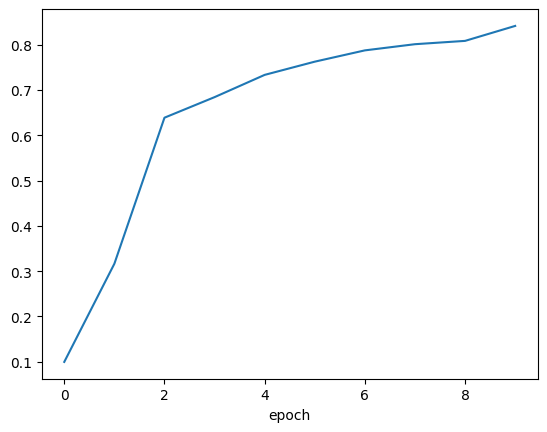

In [8]:
# train
train(model2,data.train_dataloader(),data.val_dataloader(),epochs=10)

 Class: 		 Accuracy: 		 Precision: 		 Recall: 		
  T-shirt/top: 			 0.964			 0.803			 0.891
  Trouser: 			 0.996			 0.981			 0.981
  Pullover: 			 0.932			 0.738			 0.738
  Dress: 			 0.974			 0.837			 0.891
  Coat: 			 0.938			 0.710			 0.772
  Sandal: 			 0.992			 0.949			 0.949
  Shirt: 			 0.930			 0.676			 0.489
  Sneaker: 			 0.984			 0.898			 0.936
  Bag: 			 0.998			 1.000			 0.977
  Ankle boot: 			 0.988			 0.957			 0.917

 Overall Accuracy: 	0.848
 Macro Precision: 	0.855 		 Micro Precision: 	0.848
 Macro Recall: 		0.854 		 Micro Recall: 		0.848


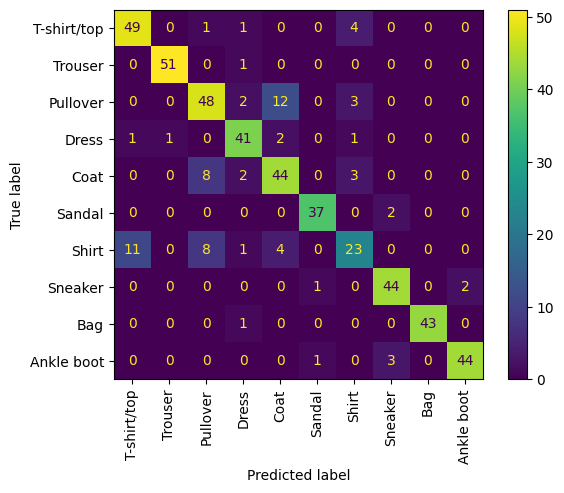

In [10]:
# better accuracy and faster training w dropout at last layer
data_2 = FashionMNIST(batch_size=500,resize=(256,256))
testloader = data_2.val_dataloader()
testdata, testlabel = next(iter(testloader))
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model2.to('cpu')
model2.eval()
logits = model2.forward(testdata)
pred = model2.predict(logits)

# display classification metrics
classification_metrics(testlabel,pred,labels=labels)

As expected, we can see better performance in the coat class from adding dropout to the output layer.  
  
Since the validation accuracy is still increasing, we can likely train for longer epochs for higher scores.